# Regression Models

Table of contents
1. [Preparing the data](#dropping-non-essential-columns-to-linear-regression)
2. [Function to visualise actual vs predicted values](#function-to-visualise-actual-vs-predicted-values)
3. [Linear Regression](#linear-regression)
   - [All features](#1a-using-all-features)
   - [Genres](#1b-using-only-genres)
   - [Studios](#1c-using-only-studios)
   - [Media Type](#1d-only-mediatype)
   - [Genres + Media Type](#1e-using-genres-and-mediatype)
4. [Cross Validation](#cross-validation)
5. [Ridge Regression](#2-ridge-regression)
6. [Lasso Regression](#3-lasso-regression)
7. [Best regression model](#analysis-of-all-regression-models)

---

### Essential Libraries

Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [249]:
# Basic Libraries
import json
import statistics
import math

from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt  # we only need pyplot

sb.set()  # set the default Seaborn style for graphics


## Advantages and disadvantages of various linear regression models

The following is from [https://statisticsbyjim.com/regression/choosing-regression-analysis/](https://statisticsbyjim.com/regression/choosing-regression-analysis/)

`Ordinary Least Squares (OLS)`
- Sensitivity to both outliers and multicollinearity
- Prone to overfitting

`Ridge regression`
- allows you to analyze data even when severe multicollinearity is present
- helps prevent overfitting
- reduces the large, problematic variance that multicollinearity causes by introducing a slight bias in the estimates
- trades away much of the variance in exchange for a little bias, which produces more useful coefficient estimates when multicollinearity is present.

`Lasso regression` (least absolute shrinkage and selection operator)
- performs variable selection that aims to increase prediction accuracy by identifying a simpler model
- It is similar to Ridge regression but with variable selection

`Partial least squares` (PLS) regression
- is useful when you have very few observations compared to the number of independent variables or when your independent variables are highly correlated. 
- PLS decreases the independent variables down to a smaller number of uncorrelated components, similar to Principal Components Analysis. 
- Then, the procedure performs linear regression on these components rather than the original data. 
- PLS emphasizes developing predictive models and is not used for screening variables. 
- Unlike OLS, you can include multiple continuous dependent variables. 
- PLS uses the correlation structure to identify smaller effects and model multivariate patterns in the dependent variables.

## Importing the data

In [250]:
anime_df = pd.read_csv('dataset/anime_cleaned_2.csv')
print("Number of animes:", len(anime_df))
anime_df.head(1)

Number of animes: 8661


,id,title,start_date,end_date,synopsis,mean,rank,popularity,num_list_users,num_scoring_users,...,broadcast_day_of_the_week,broadcast_start_time,statistics_watching,statistics_completed,statistics_on_hold,statistics_dropped,statistics_plan_to_watch,statistics_num_list_users,positive_viewership_fraction,negative_viewership_fraction
0,95,Turn A Gundam,1999-04-09,2000-04-14,"It is the Correct Century, two millennia after...",7.71,1049,2892,40743,13338,...,friday,17:00,2735.0,16661.0,2538.0,1597.0,17292.0,40823.0,0.8987,0.1013


## Dropping non-essential columns to linear regression

In [251]:
anime_df.drop([
    'title', 'start_date', 'end_date', 'id', 'synopsis', 'rank', 'popularity',
    'num_list_users', 'num_scoring_users', 'broadcast_day_of_the_week',
    'broadcast_start_time', 'statistics_watching', 'statistics_completed',
    'statistics_on_hold', 'statistics_dropped', 'statistics_plan_to_watch',
    'statistics_num_list_users', 'positive_viewership_fraction', 'negative_viewership_fraction'
],
              axis=1,
              inplace=True)


In [252]:
anime_df.head(1)

,mean,nsfw,media_type,status,genres,num_episodes,source,average_episode_duration,rating,studios,start_season_year,start_season_season
0,7.71,white,tv,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",50,original,1445,pg_13,"[{'id': 14, 'name': 'Sunrise'}, {'id': 1260, '...",1999.0,spring


## Unravel `genres` and `studios` from one column to multiple columns

In [253]:
from ipynb.fs.full.helpers import json_genres, json_studios

anime_df = json_genres(anime_df)  # convert genres column to json
anime_df = json_studios(anime_df)  # convert studios column to json

c:\Programming Projects (Not Synced)\dsai\SC1015-Project\Anime\helpers.ipynb:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "\n",
c:\Programming Projects (Not Synced)\dsai\SC1015-Project\Anime\helpers.ipynb:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "outputs": [],


In [254]:
def unravel_genre_or_studio(row):
    res = pd.Series(dtype=str)
    for elem in row:
        res = res.append(pd.Series([elem['name']]))
    res.reset_index(inplace=True, drop=True)
    return res


genres_expanded = anime_df['genres'].apply(
    lambda row: unravel_genre_or_studio(row))
genres_expanded

,0,1,2,3,4,5,6,7,8,9,10
0,Action,Adventure,Drama,Mecha,Military,Romance,Sci-Fi,Space,NaN,NaN,NaN
1,Action,Drama,Military,Sci-Fi,Space,NaN,NaN,NaN,NaN,NaN,NaN
2,Adventure,Comedy,Fantasy,Kids,Sci-Fi,Shounen,NaN,NaN,NaN,NaN,NaN
3,Action,Adventure,Comedy,Drama,Fantasy,Shounen,Super Power,NaN,NaN,NaN,NaN
4,Adventure,Comedy,Kids,Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8656,Music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8657,Comedy,Slice of Life,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8658,Adventure,Comedy,Demons,Fantasy,Historical,Supernatural,NaN,NaN,NaN,NaN,NaN
8659,Music,Supernatural,Vampire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [255]:
genres_expanded = genres_expanded.fillna('NA')

In [256]:
studios_expanded = anime_df['studios'].apply(
    lambda row: unravel_genre_or_studio(row))
studios_expanded = studios_expanded.fillna('NA')
studios_expanded

,0,1,2,3,4,5,6,7,8,9
0,Sunrise,Nakamura Production,NA,NA,NA,NA,NA,NA,NA,NA
1,Artland,Magic Bus,NA,NA,NA,NA,NA,NA,NA,NA
2,Shin-Ei Animation,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Toei Animation,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Toei Animation,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...
8656,Doga Kobo,NA,NA,NA,NA,NA,NA,NA,NA,NA
8657,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8658,Sunrise,NA,NA,NA,NA,NA,NA,NA,NA,NA
8659,A-1 Pictures,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [257]:
anime_expanded_df = anime_df.copy()
for index, row in genres_expanded.iterrows():
    for i in genres_expanded.columns:
        anime_expanded_df.loc[index, f"genre-{i}"] = genres_expanded.iloc[index, i]
for index, row in studios_expanded.iterrows():
    for i in studios_expanded.columns:
        anime_expanded_df.loc[index, f"studio-{i}"] = studios_expanded.iloc[index, i]


In [258]:
anime_expanded_df.head(2)

,mean,nsfw,media_type,status,genres,num_episodes,source,average_episode_duration,rating,studios,...,studio-0,studio-1,studio-2,studio-3,studio-4,studio-5,studio-6,studio-7,studio-8,studio-9
0,7.71,white,tv,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",50,original,1445,pg_13,"[{'id': 14, 'name': 'Sunrise'}, {'id': 1260, '...",...,Sunrise,Nakamura Production,NA,NA,NA,NA,NA,NA,NA,NA
1,8.07,white,ova,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 8, 'name'...",28,novel,1560,r,"[{'id': 8, 'name': 'Artland'}, {'id': 207, 'na...",...,Artland,Magic Bus,NA,NA,NA,NA,NA,NA,NA,NA


### Encoding nominal (unordered) categorical variables using `OneHotEncoding`

Our dataset contains a lot of categorical variables such as:
- media_type
- source
- rating
- start_season_season
- start_season_year
- status
- nsfw
- genres
- studios

In [259]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
cat_variables = [
    'media_type', 'source', 'rating', 'start_season_season',
    'start_season_year', 'status', 'nsfw'
] + [f"genre-{i}" for i in genres_expanded.columns] + [f"studio-{i}" for i in studios_expanded.columns]
anime_cat = anime_expanded_df[cat_variables]

ohe.fit(anime_cat)
anime_cat_ohe = pd.DataFrame(ohe.transform(anime_cat).toarray(),
                             columns=ohe.get_feature_names(anime_cat.columns))

# Check the encoded variables
anime_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8661 entries, 0 to 8660
Columns: 917 entries, media_type_movie to studio-9_Steve N' Steven
dtypes: float64(917)
memory usage: 60.6 MB


In [260]:
num_variable = []
for i in anime_df:
    if i not in cat_variables:
        num_variable.append(i)
num_variable

['mean', 'genres', 'num_episodes', 'average_episode_duration', 'studios']

In [261]:
# Combining Numeric features with the OHE Categorical features
animeData_num = anime_df[num_variable]
animeData_ohe = pd.concat([animeData_num, anime_cat_ohe],
                          sort=False,
                          axis=1).reindex(index=animeData_num.index)

# Check the final dataframe
animeData_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8661 entries, 0 to 8660
Columns: 922 entries, mean to studio-9_Steve N' Steven
dtypes: float64(918), int64(2), object(2)
memory usage: 60.9+ MB


### Function to visualise actual vs predicted values

In [262]:
def plot_actual_vs_pred(y, y_pred, title=None):
    plot_df = pd.concat([pd.DataFrame(y, columns=['mean']), pd.DataFrame(y_pred, columns=['mean_pred'])], axis=1, join='inner')
    plot_df.sort_values(by=['mean'], inplace=True)
    plot_df.reset_index(inplace=True, drop=True)
    ax = sb.lineplot(data=plot_df)
    if title:
        ax.set_title(title)

## 1) Linear Regression

### 1a) Using `all features`

In [263]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Extract Response and Predictors
y = pd.DataFrame(animeData_ohe['mean'])
X = pd.DataFrame(animeData_ohe.drop(['mean', 'genres', 'studios'], axis=1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [264]:
from sklearn.metrics import mean_squared_error

# fit model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# predict
y_train_pred = linreg.predict(X_train)

# Goodness of Fit for Train Data
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:",
      mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:",
      np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Accuracy for Test Data
y_test_pred = linreg.predict(X_test)
print("Accuracy of Model        \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:",
      np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.7201340781111651
Mean Squared Error (MSE) 	: 0.17552094371695418
Root Mean Squared Error (RMSE) 	: 0.41895219741272893

Accuracy of Model        	Test Dataset
Explained Variance (R^2) 	: -46211329593577.484
Mean Squared Error (MSE) 	: 29635507491869.68
Root Mean Squared Error (RMSE) 	: 5443850.428866473



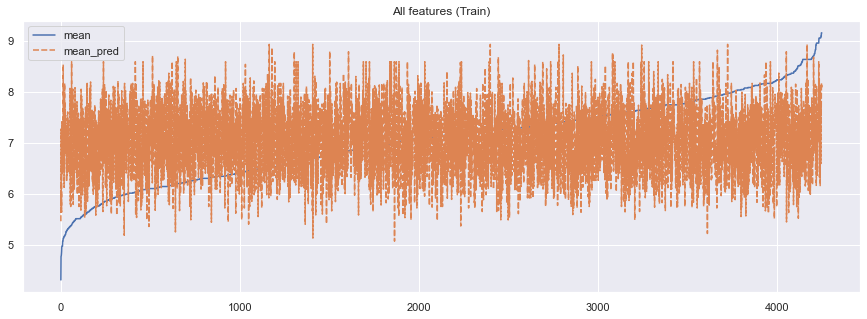

In [266]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_train, y_train_pred, title='All features (Train)')

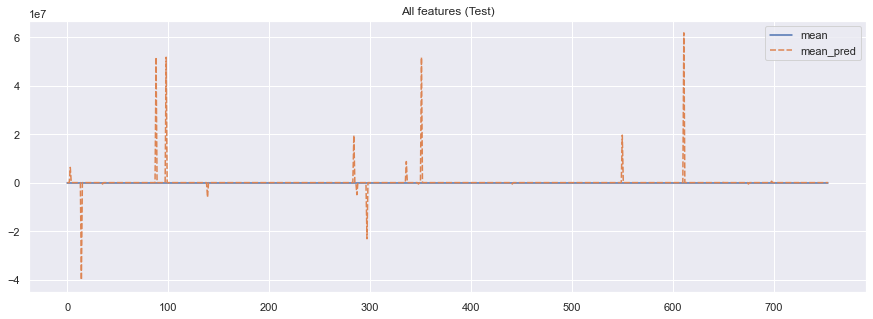

In [267]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_test, y_test_pred, title='All features (Test)')

#### 1ai) Analysis of using `all features`
- High `train` accuracy but low `test` accuracy signifies that there is *overfitting*
- The graph for the test shows that there is extreme prediction for certain ratings

Now, we will try to reduce the number of variables used.

### 1b) Using only `genres`

In [268]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Extract Response and Predictors
y = pd.DataFrame(animeData_ohe['mean'])
X = pd.DataFrame(animeData_ohe[[col for col in animeData_ohe if 'genre-' in col]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# fit model
linreg_genre = LinearRegression()
linreg_genre.fit(X_train, y_train)

# predict
y_train_pred = linreg_genre.predict(X_train)

# Goodness of Fit for Train Data
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg_genre.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:",
      mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:",
      np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Accuracy for Test Data
y_test_pred = linreg_genre.predict(X_test)
print("Accuracy of Model        \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg_genre.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:",
      np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.4653083840191925
Mean Squared Error (MSE) 	: 0.33855343904121543
Root Mean Squared Error (RMSE) 	: 0.5818534515161146

Accuracy of Model        	Test Dataset
Explained Variance (R^2) 	: 0.3805701081157107
Mean Squared Error (MSE) 	: 0.38863850341017536
Root Mean Squared Error (RMSE) 	: 0.6234087771359779



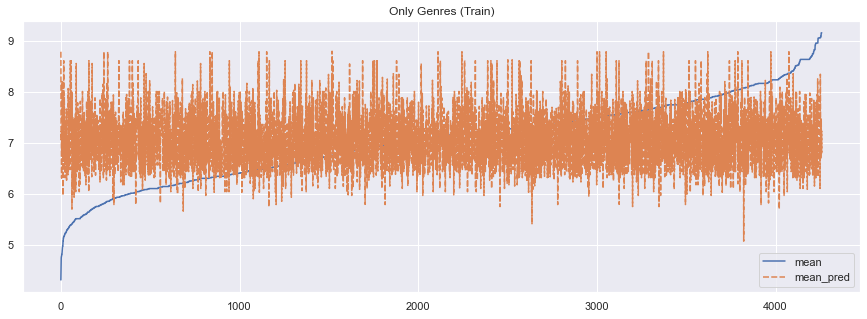

In [269]:
fg = plt.figure(figsize=(15,5))
plot_actual_vs_pred(y_train, y_train_pred, title='Only Genres (Train)')

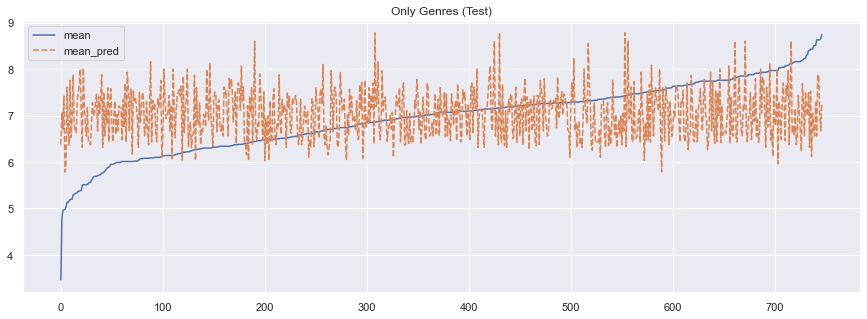

In [270]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_test, y_test_pred, title='Only Genres (Test)')

#### 1bi) Analysis of using `genres`
Explained variance of less than 0.5 signifies that just using genres is not good enough.

We need to explore other variables as well.

### 1c) using only studios

In [285]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Extract Response and Predictors
y = pd.DataFrame(animeData_ohe['mean'])
X = pd.DataFrame(
    animeData_ohe[[col for col in animeData_ohe if 'studio-' in col]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# fit model
linreg_studio = LinearRegression()
linreg_studio.fit(X_train, y_train)

# predict
y_train_pred = linreg_studio.predict(X_train)

# Goodness of Fit for Train Data
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg_studio.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:",
      mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:",
      np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Accuracy for Test Data
y_test_pred = linreg_studio.predict(X_test)
print("Accuracy of Model        \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg_studio.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:",
      np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.3924942836221821
Mean Squared Error (MSE) 	: 0.3862125044542978
Root Mean Squared Error (RMSE) 	: 0.6214599781597345

Accuracy of Model        	Test Dataset
Explained Variance (R^2) 	: -1.5566503222550413e+25
Mean Squared Error (MSE) 	: 9.6681580198639e+24
Root Mean Squared Error (RMSE) 	: 3109366176548.5103



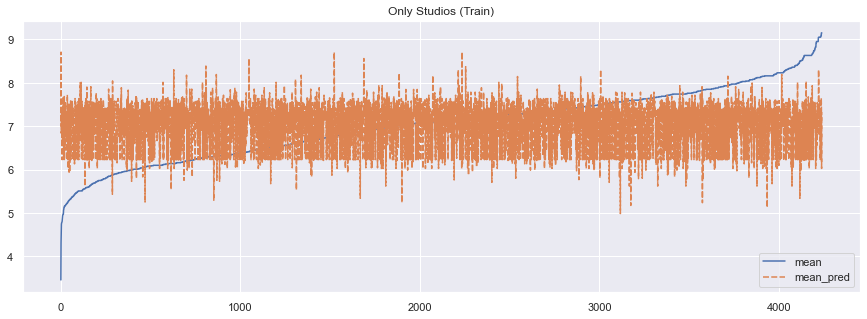

In [286]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_train, y_train_pred, title='Only Studios (Train)')

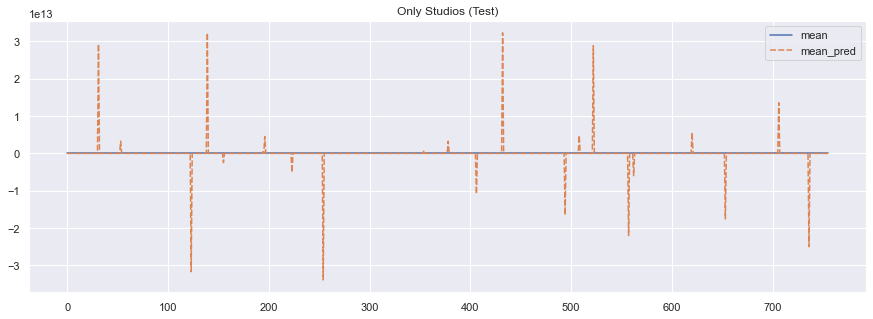

In [287]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_test, y_test_pred, title='Only Studios (Test)')

#### 1ci) Analysis of using `studios`
- Explained variance of less than 0.5 for train signifies that just using studio is not good enough.
- For test, the graph shows extreme predictions

We need to explore other variables as well.

### 1d) Only media_type

In [288]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Extract Response and Predictors
y = pd.DataFrame(animeData_ohe['mean'])
X = pd.DataFrame(animeData_ohe[[col for col in animeData_ohe if 'media_type_' in col]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# fit model
linreg_media_type = LinearRegression()
linreg_media_type.fit(X_train, y_train)

# predict
y_train_pred = linreg_media_type.predict(X_train)

# Goodness of Fit for Train Data
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg_media_type.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:",
      mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:",
      np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Accuracy for Test Data
y_test_pred = linreg_media_type.predict(X_test)
print("Accuracy of Model        \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg_media_type.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:",
      np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.09509515688566195
Mean Squared Error (MSE) 	: 0.5703465619341267
Root Mean Squared Error (RMSE) 	: 0.7552129248987511

Accuracy of Model        	Test Dataset
Explained Variance (R^2) 	: 0.105669351603767
Mean Squared Error (MSE) 	: 0.5658223087586763
Root Mean Squared Error (RMSE) 	: 0.7522116116882778



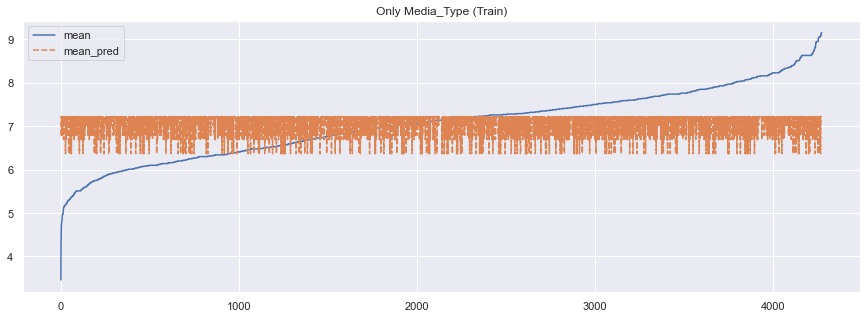

In [289]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_train, y_train_pred, title='Only Media_Type (Train)')

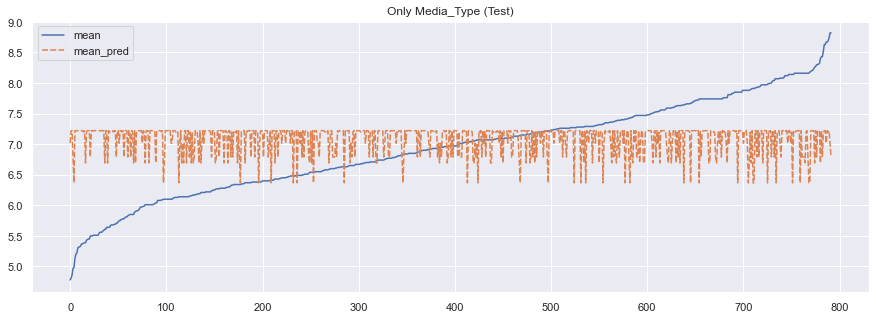

In [290]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_test, y_test_pred, title='Only Media_Type (Test)')

#### 1di) Analysis of using `media_type`
Explained variance of 0.10 signifies that just using `media_type` is a poor indicator

We need to explore other variables as well.

### 1e) Using genres and media_type

In [291]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Extract Response and Predictors
y = pd.DataFrame(animeData_ohe['mean'])
X = pd.DataFrame(animeData_ohe[[col for col in animeData_ohe if 'genre-' in col or 'media_type_' in col]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# fit model
linreg_genre_media_type = LinearRegression()
linreg_genre_media_type.fit(X_train, y_train)

# predict
y_train_pred = linreg_genre_media_type.predict(X_train)

# Goodness of Fit for Train Data
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg_genre_media_type.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:",
      mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:",
      np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Accuracy for Test Data
y_test_pred = linreg_genre_media_type.predict(X_test)
print("Accuracy of Model        \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg_genre_media_type.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:",
      np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.47620999574651357
Mean Squared Error (MSE) 	: 0.32896912590405686
Root Mean Squared Error (RMSE) 	: 0.5735583020967066

Accuracy of Model        	Test Dataset
Explained Variance (R^2) 	: 0.44383725838533683
Mean Squared Error (MSE) 	: 0.35544678133457797
Root Mean Squared Error (RMSE) 	: 0.5961935770658536



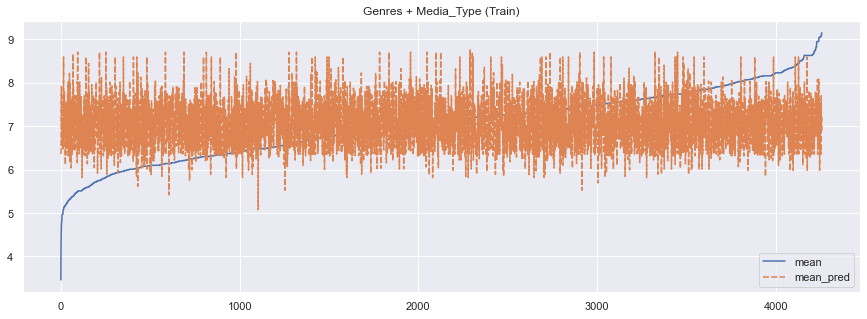

In [292]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_train, y_train_pred, title='Genres + Media_Type (Train)')

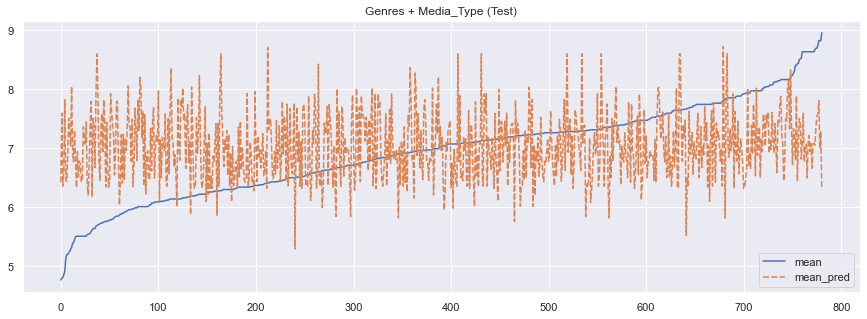

In [293]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_test, y_test_pred, title='Genres + Media_Type (Test)')

#### 1ei) Analysis of using `media_type`
Explained variance of 0.5 signifies that just using `genres` and `media_type` is not enough

We need to explore other variables as well.

### Cross validation function

In [294]:
# get mean of explained variance [r2] with 5 fold cross-validation
def get_cv_r2(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f'R2 mean: {np.mean(scores)}')

### 2) Ridge Regression
Ridge regression can help reduce the complexity of our model to prevent overfitting

In [295]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV

# Extract Response and Predictors
y = pd.DataFrame(animeData_ohe['mean'])
X = pd.DataFrame(animeData_ohe.drop(['mean', 'genres', 'studios'], axis=1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train model
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)

# get cross val scores
get_cv_r2(ridge, X_train, y_train)

# determine best alpha
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge,
                    param_grid=param_grid,
                    scoring='r2',
                    verbose=1,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best r2:\t ', grid_result.best_score_)
print('Best alpha:\t ', grid_result.best_params_['alpha'])

R2 mean: 0.6303206510649435
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best r2:	  0.6303206510649435
Best alpha:	  1


In [296]:
# Calculate accuracy for the most optimal model
optimal_ridge = Ridge(alpha=grid_result.best_params_['alpha'])
optimal_ridge.fit(X_train, y_train)
print("Accuracy (R2)")
print("Train:\t", optimal_ridge.score(X_train, y_train))
print("Test:\t", optimal_ridge.score(X_test, y_test))

Accuracy (R2)
Train:	 0.717108146712832
Test:	 0.621522854842984


In [297]:
y_train_pred_ridge = optimal_ridge.predict(X_train)
y_test_pred_ridge = optimal_ridge.predict(X_test)


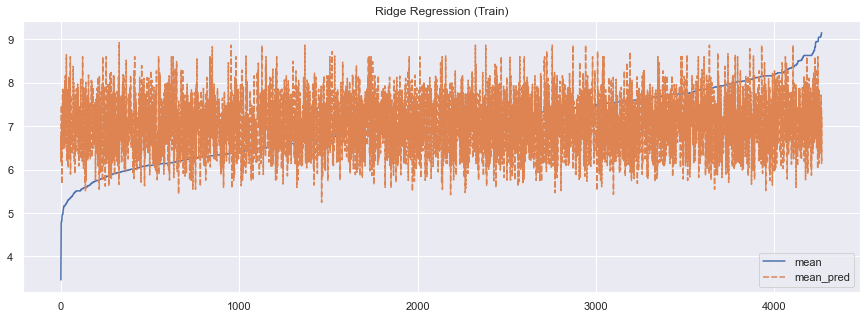

In [298]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_train,
                    y_train_pred_ridge,
                    title='Ridge Regression (Train)')

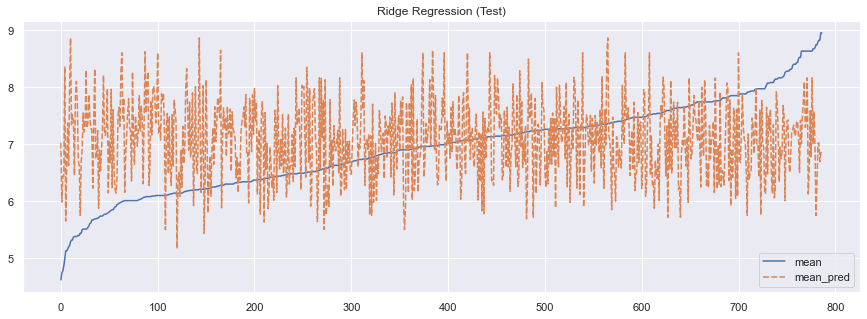

In [299]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_test,
                    y_test_pred_ridge,
                    title='Ridge Regression (Test)')

#### Analysis of Ridge Regression

`R2` of train and test is greater than that of linear regression and is above `0.5`

Hence, ridge regression is a better model than linear regression

### 3) Lasso Regression

As we have `300+` features, we can use lasso regression to select those that are the most important.

In [300]:
from sklearn.linear_model import Lasso

# Train model
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

# get cross val scores
get_cv_r2(lasso, X_train, y_train)

# determine best alpha
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso,
                    param_grid=param_grid,
                    scoring='r2',
                    verbose=1,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best r2:\t ', grid_result.best_score_)
print('Best alpha:\t ', grid_result.best_params_['alpha'])

R2 mean: 0.07421256391842783
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best r2:	  0.595355560206572
Best alpha:	  0.001


In [301]:
# Calculate accuracy for the most optimal model
optimal_lasso = Lasso(alpha=grid_result.best_params_['alpha'])
optimal_lasso.fit(X_train, y_train)
print("Accuracy (R2)")
print("Train:\t", optimal_lasso.score(X_train, y_train))
print("Test:\t", optimal_lasso.score(X_test, y_test))

Accuracy (R2)
Train:	 0.6233537183342373
Test:	 0.5747580035508786


In [302]:
y_train_pred = optimal_lasso.predict(X_train)
y_test_pred = optimal_lasso.predict(X_test)


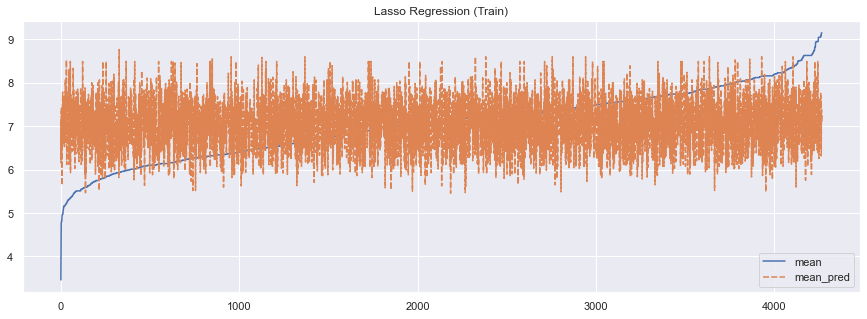

In [303]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_train,
                    y_train_pred,
                    title='Lasso Regression (Train)')

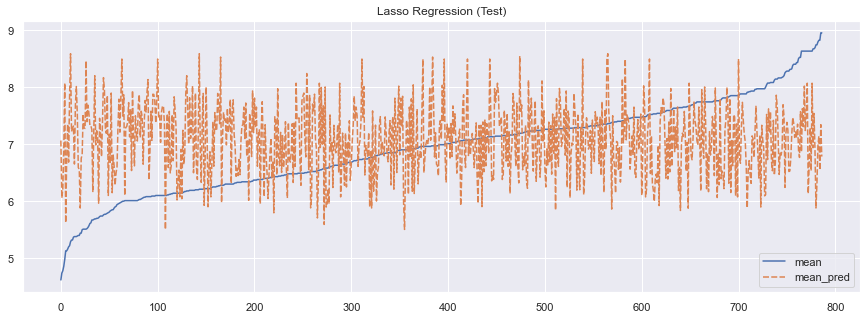

In [304]:
fg = plt.figure(figsize=(15, 5))
plot_actual_vs_pred(y_test, y_test_pred, title='Lasso Regression (Test)')


#### Analysis of Lasso Regression

`R2` of train and test is greater than that of linear regression and is above `0.5` but is lower than that of ridge regression

Hence, lasso regression is a better model than linear regression but is a poorer model than ridge regression

### Best regression model

Ranking of regression models:
1. Ridge regression (`~0.7`)
2. Lasso regression (`~0.6`)
3. Linear regression (`~0.4`)

Why ridge regression worked better:
- We had an enormous amount of variables in our dataset (`900+ variables`) and using normal linear regression to fit all the variables may result in overfitting
- Ridge regression helps minimise overfitting by regularising the coefficients. This causes some coefficients to be near `0`.
- This helps us to select relevant features by making the coefficients of irrelevant features to be almost 0.
- Hence, ridge regression reduces overfitting and increases the performance of the model.

Why lasso regression performed slightly worse than ridge regression:
- Lasso regression made the coefficients of some variables `0`.
- This could have reduced the accuracy as the variables might have had some impact on the prediction as well
- Hence, it performed slightly worse than ridge regression